# Proyecto clasificador de imágenes: gatos vs perros

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import time

Define Paths for Training and Validation Folders:



In [14]:
train_folder = '../data/raw/train'
validation_folder = '../data/raw/test1'

Identify and Separate Dog and Cat Images:



In [15]:
dog_images = []
cat_images = []

In [16]:
for filename in os.listdir(train_folder):
    file_path = os.path.join(train_folder, filename)

    if os.path.isfile(file_path):
        if 'dog' in filename.lower() and len(dog_images) < 2000:
            dog_images.append(filename)
        elif 'cat' in filename.lower() and len(cat_images) < 2000:
            cat_images.append(filename)

In [17]:
print("Perros:", dog_images)
print("Gatos:", cat_images)

Perros: ['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.1000.jpg', 'dog.10000.jpg', 'dog.10001.jpg', 'dog.10002.jpg', 'dog.10003.jpg', 'dog.10004.jpg', 'dog.10005.jpg', 'dog.10006.jpg', 'dog.10007.jpg', 'dog.10008.jpg', 'dog.10009.jpg', 'dog.1001.jpg', 'dog.10010.jpg', 'dog.10011.jpg', 'dog.10012.jpg', 'dog.10013.jpg', 'dog.10014.jpg', 'dog.10015.jpg', 'dog.10016.jpg', 'dog.10017.jpg', 'dog.10018.jpg', 'dog.10019.jpg', 'dog.1002.jpg', 'dog.10020.jpg', 'dog.10021.jpg', 'dog.10022.jpg', 'dog.10023.jpg', 'dog.10024.jpg', 'dog.10025.jpg', 'dog.10026.jpg', 'dog.10027.jpg', 'dog.10028.jpg', 'dog.10029.jpg', 'dog.1003.jpg', 'dog.10030.jpg', 'dog.10031.jpg', 'dog.10032.jpg', 'dog.10033.jpg', 'dog.10034.jpg', 'dog.10035.jpg', 'dog.10036.jpg', 'dog.10037.jpg', 'dog.10038.jpg', 'dog.10039.jpg', 'dog.1004.jpg', 'dog.10040.jpg', 'dog.10041.jpg', 'dog.10042.jpg', 'dog.10043.jpg', 'dog.10044.jpg', 'dog.10045.jpg', 'dog.10046.jpg', 'dog.10047.jpg', 'dog.10048.jpg', 'dog.10049.jpg', 'dog.1

Display Top 4 Dog and Cat Images:



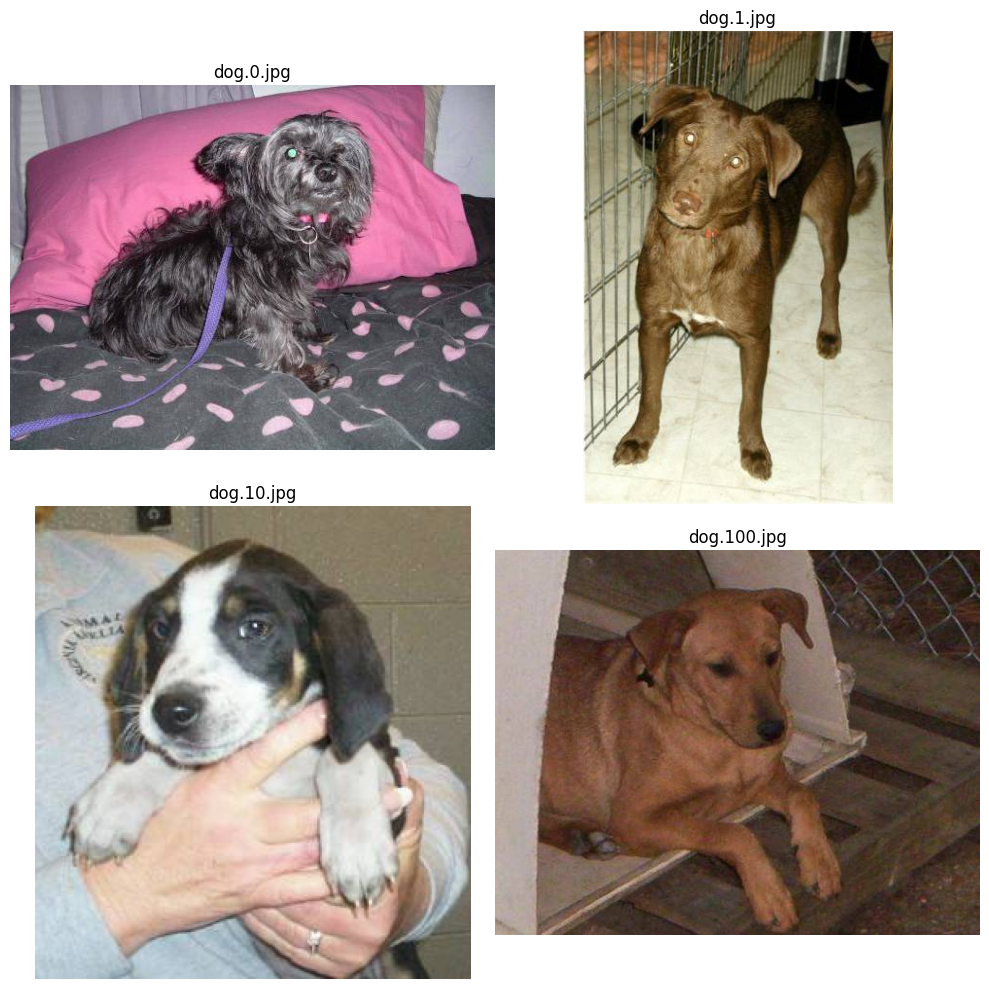

In [18]:
top_4_dog_images = dog_images[:4]

plt.figure(figsize=(10, 10)) 

for i, dog_image in enumerate(top_4_dog_images):
    img_path = os.path.join(train_folder, dog_image)
    img = Image.open(img_path)
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(dog_image)
    plt.axis('off')

plt.tight_layout()
plt.show()

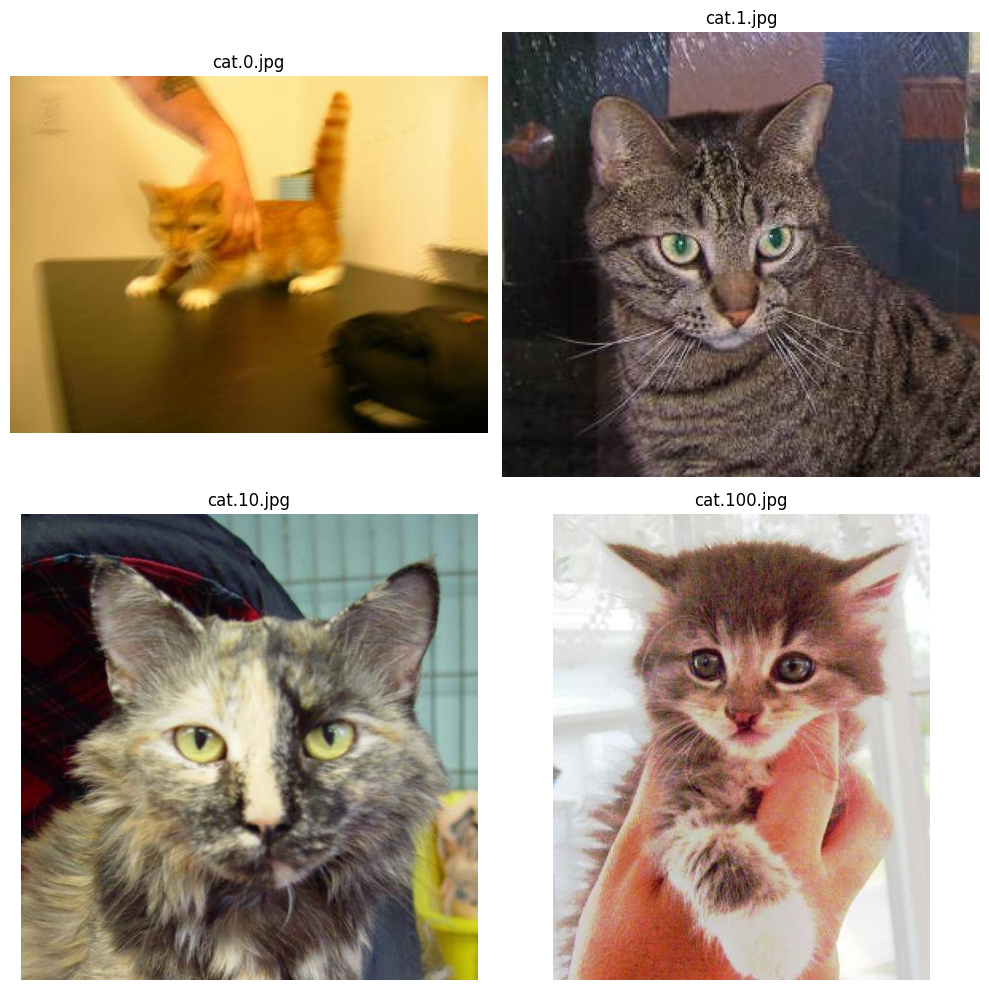

In [21]:
top_4_cat_images = cat_images[:4]


plt.figure(figsize=(10, 10)) 

for i, dog_image in enumerate(top_4_cat_images):
    img_path = os.path.join(train_folder, dog_image)
    img = Image.open(img_path)
    
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(dog_image)
    plt.axis('off')

plt.tight_layout()
plt.show()

Convert Filenames to Full Paths and Create Labels:

In [22]:
dog_paths = [os.path.join(train_folder, img) for img in dog_images]
cat_paths = [os.path.join(train_folder, img) for img in cat_images]

all_paths = dog_paths + cat_paths
all_labels = ['dog'] * len(dog_paths) + ['cat'] * len(cat_paths)

Preprocess Images in Batches:

In [23]:
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(200, 200))  
    img_array = img_to_array(img) / 255.0 
    return img_array

In [24]:
def batch_load_and_preprocess_images(image_paths, batch_size=100):
    all_images = []
    num_batches = len(image_paths) // batch_size + int(len(image_paths) % batch_size != 0)
    
    for i in range(num_batches):
        start_time = time.time()
        
        batch_paths = image_paths[i * batch_size : (i + 1) * batch_size]
        batch_images = [load_and_preprocess_image(img_path) for img_path in batch_paths]
        
        all_images.extend(batch_images)
        
        end_time = time.time()
        print(f"Processed batch {i + 1}/{num_batches} in {end_time - start_time:.2f} seconds.")
    
    return np.array(all_images)

In [ ]:
all_images = batch_load_and_preprocess_images(all_paths, batch_size=250)

Processed batch 1/16 in 3.14 seconds.
Processed batch 2/16 in 3.00 seconds.
Processed batch 3/16 in 2.82 seconds.
Processed batch 4/16 in 2.80 seconds.
Processed batch 5/16 in 2.75 seconds.
Processed batch 6/16 in 2.80 seconds.
Processed batch 7/16 in 3.43 seconds.


Convert Labels to Categorical Format:

In [12]:
label_dict = {'dog': 0, 'cat': 1}
all_labels_encoded = np.array([label_dict[label] for label in all_labels])
all_labels_categorical = to_categorical(all_labels_encoded)

Split Data into Training and Validation Sets:



In [13]:
X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels_categorical, test_size=0.2, random_state=42)

Set Up Data Augmentation for Training:

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [15]:
train_data = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_data = ImageDataGenerator().flow(X_val, y_val, batch_size=32, shuffle=True)

Build and Compile the CNN Model:

In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),  # First convolutional layer with ReLU
    MaxPooling2D((2, 2)),                                              # First pooling layer
    Conv2D(64, (3, 3), activation='relu'),                             # Second convolutional layer
    MaxPooling2D((2, 2)),                                              # Second pooling layer
    Conv2D(128, (3, 3), activation='relu'),                            # Third convolutional layer
    MaxPooling2D((2, 2)),                                              # Third pooling layer
    Flatten(),                                                         # Flattening the output for dense layers
    Dense(128, activation='relu'),                                     # Fully connected layer
    Dense(2, activation='softmax')                                     # Output layer for binary classification (dog/cat)
])

d:\01A-TRABAJO\PYTHON\DATASCIENCE\EJERCICIOS\IMAGECLASSIFIER\imagevenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the Model:



In [17]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Summary of model architecture:

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,667,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,760,770 (33.42 MB)

 Trainable params: 8,760,770 (33.42 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model, Setting Up Model Checkpoints and Early Stopping:

In [19]:
epochs = 15

In [20]:
# Define ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint(
    filepath='../models/best_model.keras', 
    monitor='val_accuracy',              
    verbose=1,                           
    save_best_only=False,                 # Save every epoch
    mode='max'
)

In [21]:
# Define EarlyStopping to halt training when performance stops improving
early_stopping = EarlyStopping(
    monitor='val_accuracy',              # Metric to monitor
    patience=5,                          # Number of epochs to wait for improvement
    verbose=1,                           # Verbosity level
    mode='max',                          # Maximize val_accuracy
    restore_best_weights=True            # Restore the best weights after stopping
)

In [22]:
# Train the model using the training and validation data
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_val) // 32,
    callbacks=[checkpoint]  # Include checkpoint callback to save the model
)

Epoch 1/10


d:\01A-TRABAJO\PYTHON\DATASCIENCE\EJERCICIOS\IMAGECLASSIFIER\imagevenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.5751 - loss: 0.7148
Epoch 1: saving model to ../models/best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 312s 492ms/step - accuracy: 0.5752 - loss: 0.7147 - val_accuracy: 0.7308 - val_loss: 0.5349
Epoch 2/10

Epoch 2: saving model to ../models/best_model.keras


F:\PROGRAMACION\Python\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.4244
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.6878 - loss: 0.5844
Epoch 3: saving model to ../models/best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 279s 444ms/step - accuracy: 0.6878 - loss: 0.5844 - val_accuracy: 0.7530 - val_loss: 0.4963
Epoch 4/10

Epoch 4: saving model to ../models/best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.5621
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.7124 - loss: 0.5551
Epoch 5: saving model to ../models/best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 284s 453ms/step - accuracy: 0.7124 - loss: 0.5551 - val_accuracy: 0.7386 - val_loss: 0.5124
Epoch 6/10

Epoch 6: saving model to ../models/best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accur

Evaluate the Model on Test Data

In [25]:
model = load_model('../models/best_model.keras')

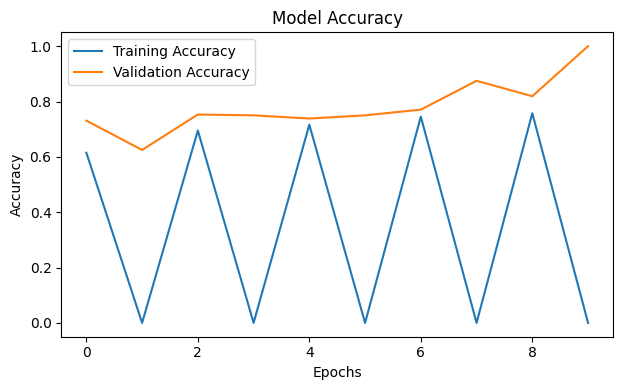

In [32]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

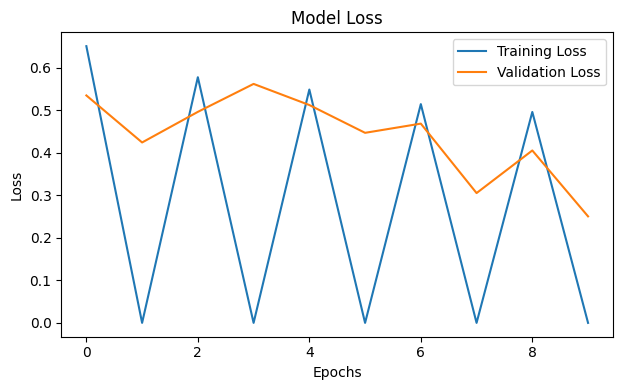

In [31]:
# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
image_value = "5" #Select a value from 1 to 12500 to choose a picture to be tested on the model.

# Load and preprocess a new test image
new_image_path = f'../data/raw/test1/{image_value}.jpg'  
img = load_img(new_image_path, target_size=(200, 200))
img_array = img_to_array(img) / 255.0  # Normalize image
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

In [43]:
# Predict the class of the new image
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


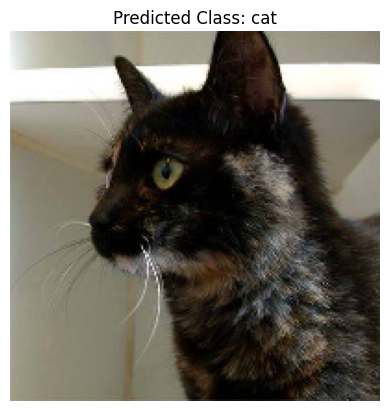

In [45]:
# Map the predicted class to the label
label_map = {0: 'dog', 1: 'cat'}
predicted_label = label_map[predicted_class]

# Display the image and prediction
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_label}")
plt.axis('off')
plt.show()